# Forecasting multiple dependent time series
## Multivariate Forecast
Conda environment: `time-series`   
27 May 2024

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from feature_engine.creation import CyclicalFeatures

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

from skforecast.datasets import fetch_dataset
# Multiple dependent series forecasting (Direct)
from skforecast.ForecasterAutoregMultiVariate import ForecasterAutoregMultiVariate

In [2]:
# Configs

# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plotsize = (22, 5)
plt.rcParams['figure.figsize'] = plotsize

# Pandas config
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_columns = 200

## 1) Input data

In [3]:
# Load the data
data = fetch_dataset(name="air_quality_valencia", raw=True)
data

air_quality_valencia
--------------------
Hourly measures of several air quimical pollutant (pm2.5, co, no, no2, pm10,
nox, o3, so2) at Valencia city.
 Red de Vigilancia y Control de la Contaminación Atmosférica, 46250054-València
- Centre, https://mediambient.gva.es/es/web/calidad-ambiental/datos-historicos.
Shape of the dataset: (26129, 11)


,datetime,pm2.5,co,no,no2,pm10,nox,o3,veloc.,direc.,so2
0,2020-01-01 00:00:00,77.0000,0.2000,16.0000,45.0000,83.0000,69.0000,3.0000,0.3000,16.0000,7.0000
1,2020-01-01 01:00:00,65.0000,0.2000,20.0000,37.0000,70.0000,68.0000,3.0000,0.2000,21.0000,5.0000
2,2020-01-01 02:00:00,47.0000,0.1000,16.0000,35.0000,51.0000,61.0000,3.0000,0.2000,35.0000,5.0000
3,2020-01-01 03:00:00,43.0000,0.1000,16.0000,29.0000,46.0000,53.0000,3.0000,0.1000,71.0000,5.0000
4,2020-01-01 04:00:00,36.0000,0.1000,10.0000,23.0000,39.0000,39.0000,3.0000,0.1000,236.0000,4.0000
...,...,...,...,...,...,...,...,...,...,...,...
26124,2019-12-31 19:00:00,31.0000,0.3000,1.0000,29.0000,33.0000,31.0000,35.0000,0.1000,162.0000,3.0000
26125,2019-12-31 20:00:00,34.0000,0.2000,33.0000,57.0000,37.0000,107.0000,6.0000,0.1000,172.0000,5.0000
26126,2019-12-31 21:00:00,47.0000,0.3000,92.0000,73.0000,50.0000,213.0000,3.0000,0.2000,289.0000,9.0000
26127,2019-12-31 22:00:00,54.0000,0.2000,30.0000,58.0000,58.0000,103.0000,3.0000,0.2000,356.0000,7.0000


### 1.1) Preprocessing

In [4]:
# Data preprocessing
air_pollutants = ["pm2.5", "co", "no", "no2", "pm10", "nox", "o3", "so2"]

data["datetime"] = pd.to_datetime(data["datetime"])
data = data.set_index("datetime")
data = data.asfreq("H")
data = data.sort_index()
data

,pm2.5,co,no,no2,pm10,nox,o3,veloc.,direc.,so2
datetime,,,,,,,,,,
2019-01-01 00:00:00,19.0000,0.2000,3.0000,36.0000,22.0000,40.0000,16.0000,0.5000,262.0000,8.0000
2019-01-01 01:00:00,26.0000,0.1000,2.0000,40.0000,32.0000,44.0000,6.0000,0.6000,248.0000,8.0000
2019-01-01 02:00:00,31.0000,0.1000,11.0000,42.0000,36.0000,58.0000,3.0000,0.3000,224.0000,8.0000
2019-01-01 03:00:00,30.0000,0.1000,15.0000,41.0000,35.0000,63.0000,3.0000,0.2000,220.0000,10.0000
2019-01-01 04:00:00,30.0000,0.1000,16.0000,39.0000,36.0000,63.0000,3.0000,0.4000,221.0000,11.0000
...,...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00,31.0000,0.1000,20.0000,36.0000,34.0000,66.0000,13.0000,0.1000,87.0000,3.0000
2021-12-31 20:00:00,33.0000,0.1000,25.0000,38.0000,39.0000,75.0000,13.0000,0.1000,67.0000,4.0000
2021-12-31 21:00:00,34.0000,0.1000,24.0000,36.0000,42.0000,73.0000,13.0000,0.1000,84.0000,5.0000


In [5]:
# Impute missing values with forward filling
data = data.ffill()

### 1.2) EDA

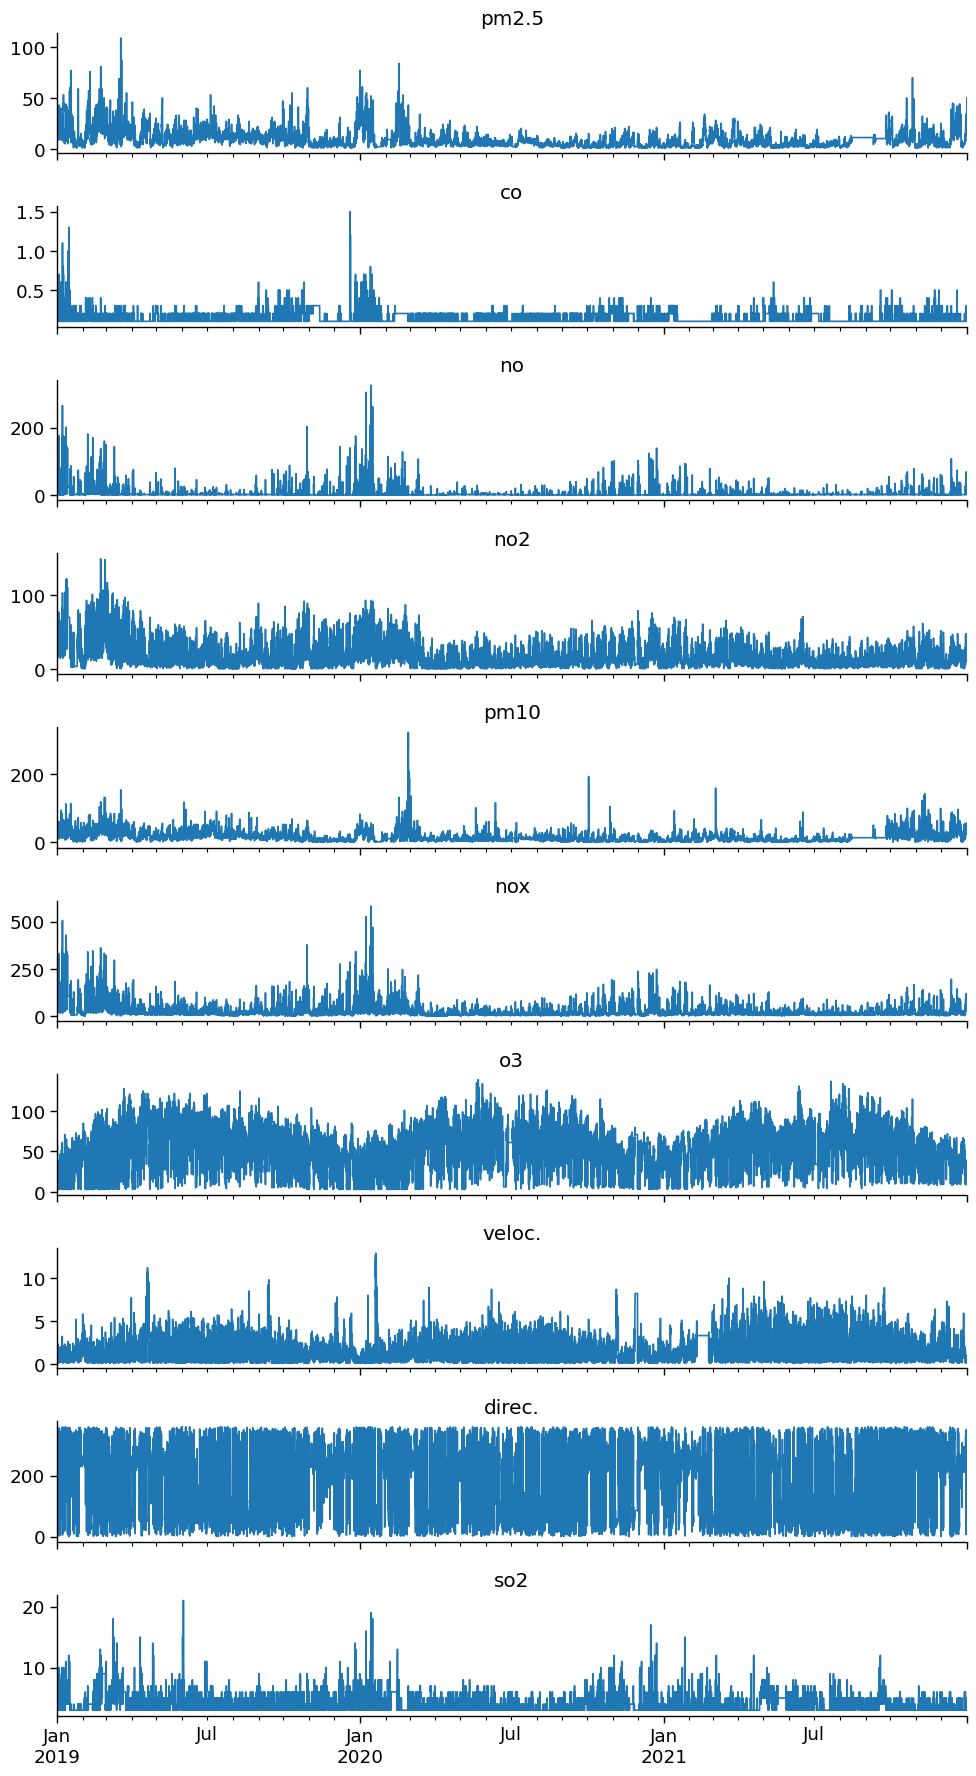

In [6]:
# Plot time series
n_cols = len(data.columns)
fig, axes = plt.subplots(nrows=n_cols, ncols=1, sharex=True, figsize=(10,18))

for col, ax in zip(data.columns, axes):
    data[col].plot(ax=ax)
    ax.set_title(col)

plt.xlabel("")
plt.tight_layout()

### 1.3) Feature Engineering

In [10]:
data["day_of_week"] = data.index.weekday
data["hour"] = data.index.hour

# Cyclical encoding
cyclical_transformer = CyclicalFeatures(variables=["day_of_week", "hour"])
data = cyclical_transformer.fit_transform(data)
data

,pm2.5,co,no,no2,pm10,nox,o3,veloc.,direc.,so2,day_of_week,hour,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos
datetime,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,19.0000,0.2000,3.0000,36.0000,22.0000,40.0000,16.0000,0.5000,262.0000,8.0000,1,0,0.8660,0.5000,0.0000,1.0000
2019-01-01 01:00:00,26.0000,0.1000,2.0000,40.0000,32.0000,44.0000,6.0000,0.6000,248.0000,8.0000,1,1,0.8660,0.5000,0.2698,0.9629
2019-01-01 02:00:00,31.0000,0.1000,11.0000,42.0000,36.0000,58.0000,3.0000,0.3000,224.0000,8.0000,1,2,0.8660,0.5000,0.5196,0.8544
2019-01-01 03:00:00,30.0000,0.1000,15.0000,41.0000,35.0000,63.0000,3.0000,0.2000,220.0000,10.0000,1,3,0.8660,0.5000,0.7308,0.6826
2019-01-01 04:00:00,30.0000,0.1000,16.0000,39.0000,36.0000,63.0000,3.0000,0.4000,221.0000,11.0000,1,4,0.8660,0.5000,0.8879,0.4601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00,31.0000,0.1000,20.0000,36.0000,34.0000,66.0000,13.0000,0.1000,87.0000,3.0000,4,19,-0.8660,-0.5000,-0.8879,0.4601
2021-12-31 20:00:00,33.0000,0.1000,25.0000,38.0000,39.0000,75.0000,13.0000,0.1000,67.0000,4.0000,4,20,-0.8660,-0.5000,-0.7308,0.6826
2021-12-31 21:00:00,34.0000,0.1000,24.0000,36.0000,42.0000,73.0000,13.0000,0.1000,84.0000,5.0000,4,21,-0.8660,-0.5000,-0.5196,0.8544


## 2) Multivariate Forecasting
![image](./img/forecaster_multivariate_train_matrix_diagram.png)

In [12]:
HORIZON = 24

# Time series variables
variables = air_pollutants + ["veloc.", "direc."]

# Exogenous feature column names
exog_cols = ["hour_sin", "hour_cos", "day_of_week_sin", "day_of_week_cos"]

### 2.1) Exogenous Features

In [20]:
# Prepare exogenous features for the future
freq = data.index.freq.name
future_start_date = data.index.max() + pd.Timedelta(f"1{freq}")
future_dates = pd.date_range(start=future_start_date, freq=freq, periods=HORIZON + 1)

future_exog = pd.DataFrame(index=future_dates)
future_exog["hour"] = future_exog.index.hour
future_exog["day_of_week"] = future_exog.index.weekday
future_exog = cyclical_transformer.fit_transform(future_exog)
future_exog

,hour,day_of_week,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos
2022-01-01 00:00:00,0,5,-0.8660,0.5000,0.0000,1.0000
2022-01-01 01:00:00,1,5,-0.8660,0.5000,0.2698,0.9629
2022-01-01 02:00:00,2,5,-0.8660,0.5000,0.5196,0.8544
2022-01-01 03:00:00,3,5,-0.8660,0.5000,0.7308,0.6826
2022-01-01 04:00:00,4,5,-0.8660,0.5000,0.8879,0.4601
2022-01-01 05:00:00,5,5,-0.8660,0.5000,0.9791,0.2035
2022-01-01 06:00:00,6,5,-0.8660,0.5000,0.9977,-0.0682
2022-01-01 07:00:00,7,5,-0.8660,0.5000,0.9423,-0.3349
2022-01-01 08:00:00,8,5,-0.8660,0.5000,0.8170,-0.5767
2022-01-01 09:00:00,9,5,-0.8660,0.5000,0.6311,-0.7757


### 2.2) Linear-models: Ridge

#### 2.2.1) CO: carbon monoxide

In [13]:
forecast_target = "co"

# Define the forecaster
forecaster = ForecasterAutoregMultiVariate(
    regressor=Ridge(alpha=1),
    level=forecast_target,
    lags=24,
    steps=HORIZON,
    transformer_series=StandardScaler(),
    transformer_exog=StandardScaler(),
)

In [15]:
# QC
X_train, y_train = forecaster.create_train_X_y(
    series=data[variables], exog=data[exog_cols]
)

X_train.head()

,pm2.5_lag_1,pm2.5_lag_2,pm2.5_lag_3,pm2.5_lag_4,pm2.5_lag_5,pm2.5_lag_6,pm2.5_lag_7,pm2.5_lag_8,pm2.5_lag_9,pm2.5_lag_10,pm2.5_lag_11,pm2.5_lag_12,pm2.5_lag_13,pm2.5_lag_14,pm2.5_lag_15,pm2.5_lag_16,pm2.5_lag_17,pm2.5_lag_18,pm2.5_lag_19,pm2.5_lag_20,pm2.5_lag_21,pm2.5_lag_22,pm2.5_lag_23,pm2.5_lag_24,co_lag_1,co_lag_2,co_lag_3,co_lag_4,co_lag_5,co_lag_6,co_lag_7,co_lag_8,co_lag_9,co_lag_10,co_lag_11,co_lag_12,co_lag_13,co_lag_14,co_lag_15,co_lag_16,co_lag_17,co_lag_18,co_lag_19,co_lag_20,co_lag_21,co_lag_22,co_lag_23,co_lag_24,no_lag_1,no_lag_2,no_lag_3,no_lag_4,no_lag_5,no_lag_6,no_lag_7,no_lag_8,no_lag_9,no_lag_10,no_lag_11,no_lag_12,no_lag_13,no_lag_14,no_lag_15,no_lag_16,no_lag_17,no_lag_18,no_lag_19,no_lag_20,no_lag_21,no_lag_22,no_lag_23,no_lag_24,no2_lag_1,no2_lag_2,no2_lag_3,no2_lag_4,no2_lag_5,no2_lag_6,no2_lag_7,no2_lag_8,no2_lag_9,no2_lag_10,no2_lag_11,no2_lag_12,no2_lag_13,no2_lag_14,no2_lag_15,no2_lag_16,no2_lag_17,no2_lag_18,no2_lag_19,no2_lag_20,no2_lag_21,no2_lag_22,no2_lag_23,no2_lag_24,pm10_lag_1,pm10_lag_2,pm10_lag_3,pm10_lag_4,...,direc._lag_21,direc._lag_22,direc._lag_23,direc._lag_24,hour_sin_step_1,hour_cos_step_1,day_of_week_sin_step_1,day_of_week_cos_step_1,hour_sin_step_2,hour_cos_step_2,day_of_week_sin_step_2,day_of_week_cos_step_2,hour_sin_step_3,hour_cos_step_3,day_of_week_sin_step_3,day_of_week_cos_step_3,hour_sin_step_4,hour_cos_step_4,day_of_week_sin_step_4,day_of_week_cos_step_4,hour_sin_step_5,hour_cos_step_5,day_of_week_sin_step_5,day_of_week_cos_step_5,hour_sin_step_6,hour_cos_step_6,day_of_week_sin_step_6,day_of_week_cos_step_6,hour_sin_step_7,hour_cos_step_7,day_of_week_sin_step_7,day_of_week_cos_step_7,hour_sin_step_8,hour_cos_step_8,day_of_week_sin_step_8,day_of_week_cos_step_8,hour_sin_step_9,hour_cos_step_9,day_of_week_sin_step_9,day_of_week_cos_step_9,hour_sin_step_10,hour_cos_step_10,day_of_week_sin_step_10,day_of_week_cos_step_10,hour_sin_step_11,hour_cos_step_11,day_of_week_sin_step_11,day_of_week_cos_step_11,hour_sin_step_12,hour_cos_step_12,day_of_week_sin_step_12,day_of_week_cos_step_12,hour_sin_step_13,hour_cos_step_13,day_of_week_sin_step_13,day_of_week_cos_step_13,hour_sin_step_14,hour_cos_step_14,day_of_week_sin_step_14,day_of_week_cos_step_14,hour_sin_step_15,hour_cos_step_15,day_of_week_sin_step_15,day_of_week_cos_step_15,hour_sin_step_16,hour_cos_step_16,day_of_week_sin_step_16,day_of_week_cos_step_16,hour_sin_step_17,hour_cos_step_17,day_of_week_sin_step_17,day_of_week_cos_step_17,hour_sin_step_18,hour_cos_step_18,day_of_week_sin_step_18,day_of_week_cos_step_18,hour_sin_step_19,hour_cos_step_19,day_of_week_sin_step_19,day_of_week_cos_step_19,hour_sin_step_20,hour_cos_step_20,day_of_week_sin_step_20,day_of_week_cos_step_20,hour_sin_step_21,hour_cos_step_21,day_of_week_sin_step_21,day_of_week_cos_step_21,hour_sin_step_22,hour_cos_step_22,day_of_week_sin_step_22,day_of_week_cos_step_22,hour_sin_step_23,hour_cos_step_23,day_of_week_sin_step_23,day_of_week_cos_step_23,hour_sin_step_24,hour_cos_step_24,day_of_week_sin_step_24,day_of_week_cos_step_24
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02 23:00:00,2.7061,3.1785,2.1156,0.8166,0.5804,0.5804,0.3442,-0.0100,0.1080,0.4623,0.2261,-0.1281,-0.4824,-0.4824,-0.2462,-0.0100,0.2261,0.5804,1.7613,2.4699,2.4699,2.5880,1.9975,1.1709,2.1573,3.4907,2.1573,-0.5095,-0.5095,0.8239,0.8239,-0.5095,-0.5095,-0.5095,-0.5095,-0.5095,-0.5095,-0.5095,-0.5095,-0.5095,-0.5095,-0.5095,-0.5095,-0.5095,-0.5095,-0.5095,-0.5095,0.8239,3.7641,11.4547,8.2041,1.8613,0.1171,-0.2794,-0.2794,-0.2794,-0.2794,-0.2794,-0.2794,-0.2794,-0.2794,-0.2794,-0.2794,-0.2794,-0.2001,-0.2001,0.5928,0.9099,0.8306,0.5135,-0.2001,-0.1208,2.0899,2.9069,2.7812,2.9697,2.8440,1.5871,0.3302,-0.1726,0.0160,0.0788,0.2045,0.7073,0.7073,0.7073,1.0215,1.1472,1.2100,1.1472,1.4614,1.3986,1.5243,1.5871,1.4614,1.2100,

In [18]:
for i in X_train.columns:
    print(i)

pm2.5_lag_1
pm2.5_lag_2
pm2.5_lag_3
pm2.5_lag_4
pm2.5_lag_5
pm2.5_lag_6
pm2.5_lag_7
pm2.5_lag_8
pm2.5_lag_9
pm2.5_lag_10
pm2.5_lag_11
pm2.5_lag_12
pm2.5_lag_13
pm2.5_lag_14
pm2.5_lag_15
pm2.5_lag_16
pm2.5_lag_17
pm2.5_lag_18
pm2.5_lag_19
pm2.5_lag_20
pm2.5_lag_21
pm2.5_lag_22
pm2.5_lag_23
pm2.5_lag_24
co_lag_1
co_lag_2
co_lag_3
co_lag_4
co_lag_5
co_lag_6
co_lag_7
co_lag_8
co_lag_9
co_lag_10
co_lag_11
co_lag_12
co_lag_13
co_lag_14
co_lag_15
co_lag_16
co_lag_17
co_lag_18
co_lag_19
co_lag_20
co_lag_21
co_lag_22
co_lag_23
co_lag_24
no_lag_1
no_lag_2
no_lag_3
no_lag_4
no_lag_5
no_lag_6
no_lag_7
no_lag_8
no_lag_9
no_lag_10
no_lag_11
no_lag_12
no_lag_13
no_lag_14
no_lag_15
no_lag_16
no_lag_17
no_lag_18
no_lag_19
no_lag_20
no_lag_21
no_lag_22
no_lag_23
no_lag_24
no2_lag_1
no2_lag_2
no2_lag_3
no2_lag_4
no2_lag_5
no2_lag_6
no2_lag_7
no2_lag_8
no2_lag_9
no2_lag_10
no2_lag_11
no2_lag_12
no2_lag_13
no2_lag_14
no2_lag_15
no2_lag_16
no2_lag_17
no2_lag_18
no2_lag_19
no2_lag_20
no2_lag_21
no2_lag_22
no

In [19]:
y_train

{1: datetime
 2019-01-02 00:00:00    0.8239
 2019-01-02 01:00:00    0.8239
 2019-01-02 02:00:00    2.1573
 2019-01-02 03:00:00   -0.5095
 2019-01-02 04:00:00   -0.5095
                         ...  
 2021-12-30 20:00:00   -0.5095
 2021-12-30 21:00:00   -0.5095
 2021-12-30 22:00:00   -0.5095
 2021-12-30 23:00:00   -0.5095
 2021-12-31 00:00:00   -0.5095
 Freq: H, Name: co_step_1, Length: 26257, dtype: float64,
 2: datetime
 2019-01-02 01:00:00    0.8239
 2019-01-02 02:00:00    2.1573
 2019-01-02 03:00:00   -0.5095
 2019-01-02 04:00:00   -0.5095
 2019-01-02 05:00:00   -0.5095
                         ...  
 2021-12-30 21:00:00   -0.5095
 2021-12-30 22:00:00   -0.5095
 2021-12-30 23:00:00   -0.5095
 2021-12-31 00:00:00   -0.5095
 2021-12-31 01:00:00   -0.5095
 Freq: H, Name: co_step_2, Length: 26257, dtype: float64,
 3: datetime
 2019-01-02 02:00:00    2.1573
 2019-01-02 03:00:00   -0.5095
 2019-01-02 04:00:00   -0.5095
 2019-01-02 05:00:00   -0.5095
 2019-01-02 06:00:00   -0.5095
        

In [21]:
# Fit the model
forecaster.fit(series=data[variables], exog=data[exog_cols])

# Forecast
forecast = forecaster.predict(steps=HORIZON, exog=future_exog[exog_cols])
forecast

,co
2022-01-01 00:00:00,0.1001
2022-01-01 01:00:00,0.1093
2022-01-01 02:00:00,0.1248
2022-01-01 03:00:00,0.1417
2022-01-01 04:00:00,0.1597
2022-01-01 05:00:00,0.1729
2022-01-01 06:00:00,0.1647
2022-01-01 07:00:00,0.1540
2022-01-01 08:00:00,0.1496
2022-01-01 09:00:00,0.1386


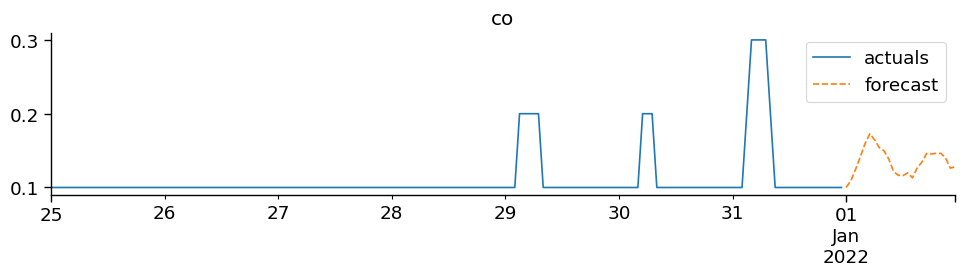

In [23]:
# Plot forecast
fig, ax = plt.subplots(figsize=[10, 3])
data.iloc[-7 * 24 :][forecast_target].plot(ax=ax, label="actuals")
forecast.loc[:, forecast_target].plot(ax=ax, linestyle="--", label="forecast")
ax.legend()
ax.set_title(f"{forecast_target}")

plt.xlabel("")
plt.tight_layout()

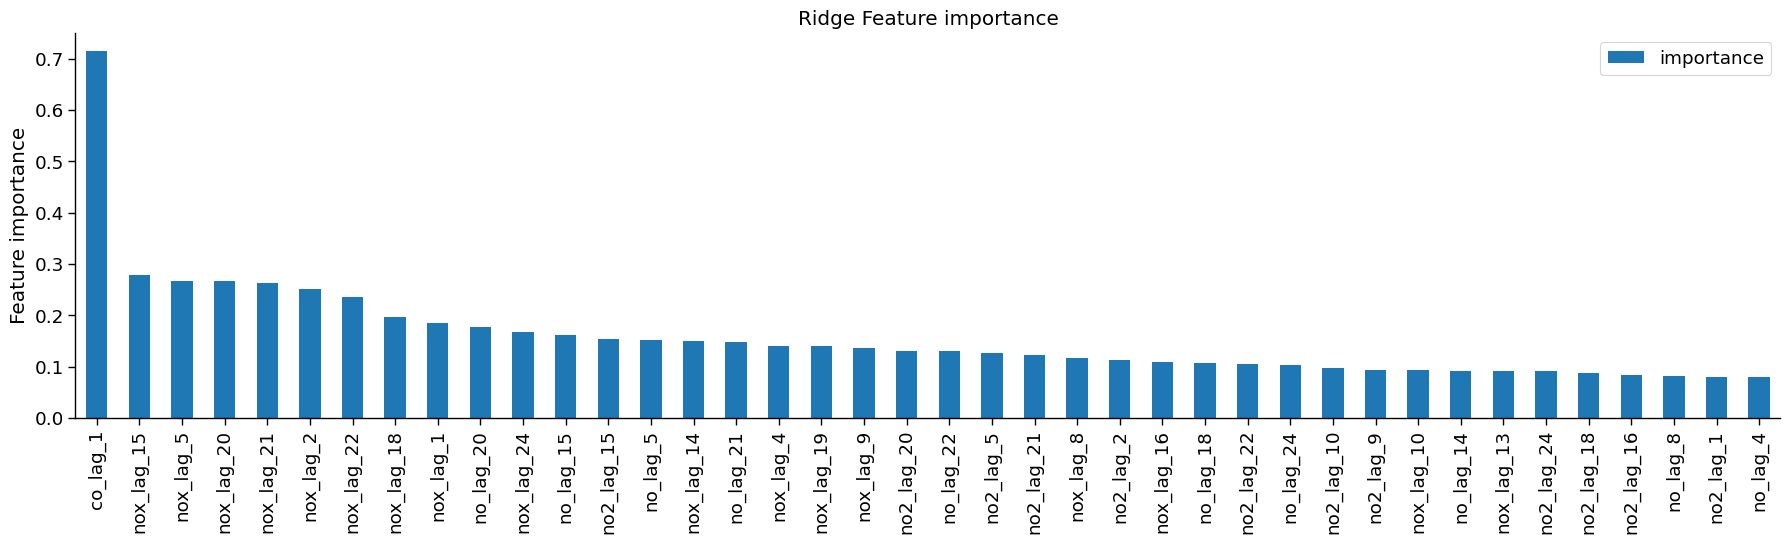

In [29]:
(
    forecaster
    .get_feature_importances(step=1)
    .assign(importance = lambda x: abs(x["importance"]))
    .sort_values("importance", ascending=False)
    .set_index("feature")
    .head(40)
    .plot(kind="bar")
)

plt.title("Ridge Feature importance")
plt.ylabel("Feature importance")
plt.xlabel("")
plt.show()

In [30]:
# See more details here: https://joaquinamatrodrigo.github.io/skforecast/0.11.0/user_guides/probabilistic-forecasting.html
forecast_intervals = forecaster.predict_interval(
    steps=HORIZON,
    exog=future_exog[exog_cols],
)
forecast_intervals.head(3)

,co,lower_bound,upper_bound
2022-01-01 00:00:00,0.1001,0.0492,0.1872
2022-01-01 01:00:00,0.1093,0.0505,0.1994
2022-01-01 02:00:00,0.1248,0.0633,0.2208


#### 2.2.2) All pollutants: Ridge

In [32]:
# Loop over each pollutant
results = []
models = dict()

for pollutant in air_pollutants:
    # Define the forecaster
    forecaster = ForecasterAutoregMultiVariate(
        regressor=Ridge(alpha=1),
        level=pollutant,
        lags=24,
        steps=HORIZON,
        transformer_series=StandardScaler(),
        transformer_exog=StandardScaler(),
    )
    # Fit the model
    forecaster.fit(series=data[variables], exog=data[exog_cols])
    # Forecast
    forecast = forecaster.predict(steps=HORIZON, exog=future_exog[exog_cols])
    models[pollutant] = forecaster
    results.append(forecast)

forecasts = pd.concat(results, axis=1)
forecasts

,pm2.5,co,no,no2,pm10,nox,o3,so2
2022-01-01 00:00:00,47.1436,0.1001,18.8333,27.0594,54.0084,55.7585,10.4180,3.2526
2022-01-01 01:00:00,42.1366,0.1093,13.5850,24.3866,48.4195,44.9440,9.1020,3.5489
2022-01-01 02:00:00,38.0711,0.1248,10.4188,21.5442,44.9675,37.3951,9.4500,3.8489
2022-01-01 03:00:00,34.6237,0.1417,8.0528,18.4138,41.0327,30.6040,11.2401,3.9554
2022-01-01 04:00:00,32.0393,0.1597,7.1956,16.9061,38.9589,27.8338,10.7553,3.9981
2022-01-01 05:00:00,30.4788,0.1729,8.5309,17.5401,37.9861,30.6151,10.3730,3.9586
2022-01-01 06:00:00,28.7513,0.1647,12.3996,17.8471,36.6400,36.7558,11.2096,3.9239
2022-01-01 07:00:00,27.8883,0.1540,23.3953,20.7723,36.7746,56.5091,10.9775,3.9779
2022-01-01 08:00:00,27.5588,0.1496,32.4228,24.4034,39.6721,74.0306,11.0161,3.9206
2022-01-01 09:00:00,26.8824,0.1386,31.4737,26.4012,43.0547,74.5421,13.4577,3.7610


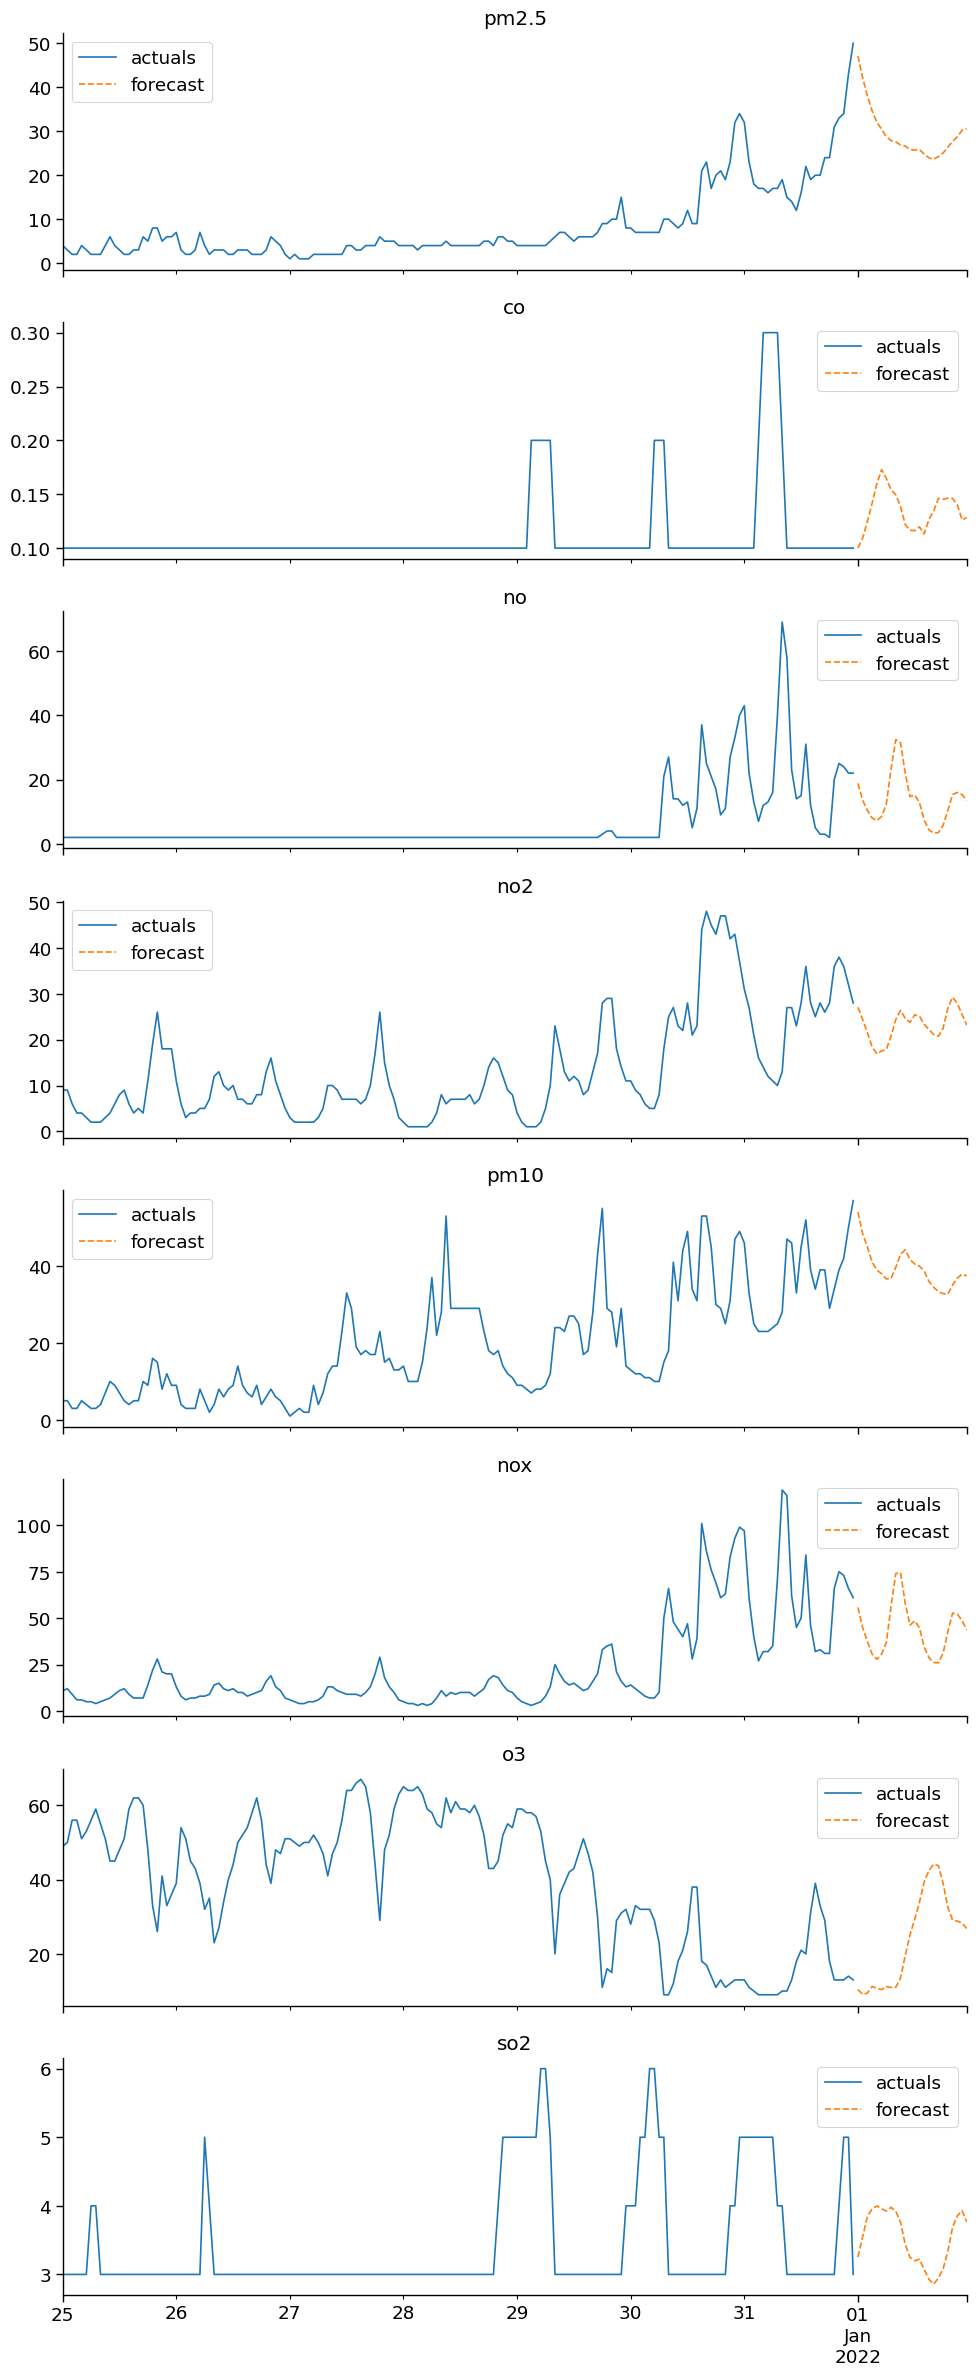

In [34]:
# Plotting
num_timeseries = len(air_pollutants)

fig, axs = plt.subplots(nrows=num_timeseries, figsize=[10, 3 * num_timeseries], sharex=True)
for pollutant, ax in zip(air_pollutants, axs):
    data.iloc[-24 * 7 :][pollutant].plot(ax=ax, label="actuals")
    forecasts.loc[:, pollutant].plot(ax=ax, linestyle="--", label="forecast")
    ax.legend()
    ax.set_title(f"{pollutant}")

plt.xlabel("")
plt.tight_layout()

### 2.2) Tree-models: Random Forest

In [35]:
# Loop over each pollutant
results = []
models = dict()

for pollutant in air_pollutants:
    # Define the forecaster
    forecaster = ForecasterAutoregMultiVariate(
        regressor=RandomForestRegressor(),
        level=pollutant,
        lags=24,
        steps=HORIZON,
        transformer_series=StandardScaler(),
        transformer_exog=StandardScaler(),
    )
    # Fit the model
    forecaster.fit(series=data[variables], exog=data[exog_cols])
    # Forecast
    forecast = forecaster.predict(steps=HORIZON, exog=future_exog[exog_cols])
    models[pollutant] = forecaster
    results.append(forecast)

forecasts = pd.concat(results, axis=1)
forecasts

In [ ]:
# Plotting
num_timeseries = len(air_pollutants)

fig, axs = plt.subplots(nrows=num_timeseries, figsize=[10, 3 * num_timeseries], sharex=True)
for pollutant, ax in zip(air_pollutants, axs):
    data.iloc[-24 * 7 :][pollutant].plot(ax=ax, label="actuals")
    forecasts.loc[:, pollutant].plot(ax=ax, linestyle="--", label="forecast")
    ax.legend()
    ax.set_title(f"{pollutant}")

plt.xlabel("")
plt.tight_layout()